In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 重抽樣

### 置換檢驗

In [2]:
# 讀取資料集
session_times = pd.read_csv("../../data/web_page_data.csv")

print(session_times.head())

     Page  Time
0  Page A  0.21
1  Page B  2.53
2  Page A  0.35
3  Page B  0.71
4  Page A  0.67


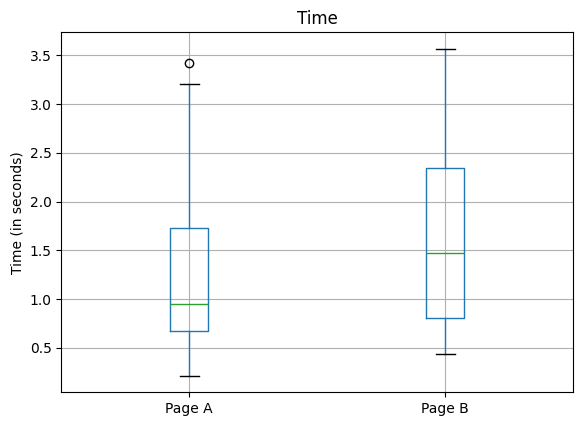

In [ ]:
# 畫boxplot 比對
ax = session_times.boxplot(by='Page', column='Time')
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('');

In [5]:
# 計算出A/B頁面平均的差值
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

0.3566666666666669


In [8]:
# 定義置換檢驗抽樣函式
import random

def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    idx_A = list(idx_A)
    idx_B = list(idx_B)
    
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

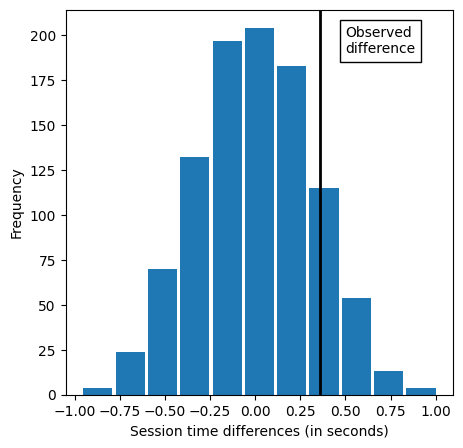

In [22]:
# 執行1000次重抽樣 並生成直方圖
nA = 21
nB = 15
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=mean_b - mean_a, color='black', lw=2)
ax.text(0.5, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency');

In [25]:
# 算出差異值在置換分布中的百分比
print(np.mean(perm_diffs > mean_b - mean_a))

0.136
